In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
import matplotlib.ticker as mticker
from matplotlib.table import Table

In [2]:
# Functions
    
# Plot the Z-Score
def plot_z_scores(data, column="Z-Score", months=24):
    """
    Plot the Z-Scores over the last `months`.

    Parameters:
    - data (pd.DataFrame): The dataset containing the Z-Score column.
    - column (str): The name of the column to plot (default is "Z-Score").
    - months (int): Number of months to filter the data for (default is 24).
    """
    
    # Paths to your Montserrat font files
    font_path = './assets/Montserrat/static/Montserrat-Regular.ttf'
    font_path_bold = './assets/Montserrat/static/Montserrat-Bold.ttf'
    
    # Register the font properties with sizes
    prop = fm.FontProperties(fname=font_path, size=12)
    prop_bold = fm.FontProperties(fname=font_path_bold, size=16)
    
    # Filter data for the past `months`
    end_date = data.index.max()
    start_date = end_date - pd.DateOffset(months=months)
    filtered_data = data[(data.index >= start_date) & (data.index <= end_date)]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data.index, filtered_data[column], label="Z-Score", marker='o', linewidth=2)

    # Add labels and title with Montserrat font
    plt.title(f"Z-Score of Brent Prices Over the Last {months} Months", fontproperties=prop_bold)
    plt.xlabel("Date", fontproperties=prop)
    plt.ylabel("Z-Score", fontproperties=prop)
    plt.axhline(0, color='red', linestyle='--', linewidth=1, label="Mean (Z=0)")
    plt.axhline(2, color='green', linestyle='--', linewidth=1, label="Threshold (+2)")
    plt.axhline(-2, color='green', linestyle='--', linewidth=1, label="Threshold (-2)")

    # Customize legend and grid
    plt.legend(prop=prop, fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    
    output_path = "../report/images/z_score_brent.png"
    plt.savefig(output_path, dpi=300)

    # Show the plot
    plt.show()

# Z Score
def calculate_z_scores(data, column="Close", months=24):
    """
    Calculate the z-score for a specified column over the past `months` period.

    Parameters:
    - data (pd.DataFrame): The dataset with a datetime index and the specified column.
    - column (str): The column to calculate z-scores for (default is "Close").
    - months (int): The number of months to include in the rolling window (default is 24).

    Returns:
    - pd.DataFrame: The original DataFrame with an additional 'Z-Score' column.
    """
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    # Filter data for the past `months` period
    end_date = data.index.max()
    start_date = end_date - pd.DateOffset(months=months)
    recent_data = data[(data.index >= start_date) & (data.index <= end_date)].copy()
    
    # Calculate mean and standard deviation for the column
    mean_value = recent_data[column].mean()
    std_dev = recent_data[column].std()

    # Calculate z-scores
    data["Z-Score"] = (data[column] - mean_value) / std_dev

    return data

# Function to display bar chart and line with MoM % Change
def plot_median_close_and_mom(data):
    # Paths to your Montserrat font files
    font_path = './assets/Montserrat/static/Montserrat-Regular.ttf'
    font_path_bold = './assets/Montserrat/static/Montserrat-Bold.ttf'

    # Register the font properties with sizes
    prop = fm.FontProperties(fname=font_path, size=12)
    prop_bold = fm.FontProperties(fname=font_path_bold, size=16)

    # Ensure the 'Date' column is a datetime object and set as the index
    data = data.copy()
    data.index = pd.to_datetime(data.index)

    # Resample data to monthly frequency and calculate median Close
    monthly_median = data['Close'].resample('M').median()

    # Calculate MoM percentage change
    mom_pct_change = monthly_median.pct_change() * 100

    # Filter the past 12 months
    last_12_months = monthly_median[-12:]
    last_12_mom = mom_pct_change[-12:]

    # Subtract one month from each x-axis label
    x_labels = [date - pd.DateOffset(months=0) for date in last_12_months.index]

    # Plot the data
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Adjust y-axis for better layout
    max_close = last_12_months.max()
    ax1.set_ylim(40, max_close * 1.15)

    # Bar chart for median Close with significantly wider bars
    bars = ax1.bar(x_labels, last_12_months, color='dodgerblue', alpha=0.7, label='Median Close', width=10)
    ax1.set_ylabel('Price Per Barrel', fontsize=14, labelpad=15, fontproperties=prop_bold)
    ax1.set_xlabel('Month', fontsize=14, labelpad=15, fontproperties=prop_bold)
    ax1.tick_params(axis='x', rotation=45, labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)

    # Set new x-axis labels
    ax1.set_xticks(x_labels)
    ax1.set_xticklabels([date.strftime('%Y-%m') for date in x_labels])

    # Add labels to the bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}', ha='center', va='bottom', fontproperties=prop)

    # Line chart for MoM % Change
    ax2 = ax1.twinx()
    ax2.set_ylim(-90, 12)
    line, = ax2.plot(x_labels, last_12_mom, color='orange', marker='o', linestyle='-', linewidth=2, label='MoM % Change')
    ax2.tick_params(axis='y', labelsize=12, right=False, labelright=False)  # Hide percentage axis

    # Add labels to the line chart
    for x, y in zip(x_labels, last_12_mom):
        ax2.text(x, y + 0.5, f'{y:.2f}%', ha='center', va='bottom', fontproperties=prop)

    # # Place legends outside the chart area on the right
    # ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12, prop=prop)
    # ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.4), fontsize=12, prop=prop)

    # Save the plot as an image
    plt.title('Past 12 Months Median Close and MoM % Change', fontsize=16, pad=20, fontproperties=prop_bold)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(pad=2)
    
    output_path = "../report/images/median_monthly_prices.png"
    plt.savefig(output_path, dpi=300)
    
    plt.show()





In [3]:
# Define the ticker symbol for Brent Crude Oil Futures
brent_ticker = "BZ=F"

# Set start and end dates
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=6 * 365)).strftime("%Y-%m-%d")

# Fetch data from Yahoo Finance
brent_data = yf.download(brent_ticker, start=start_date, end=end_date)

# Save the data to a CSV file (optional)
output_file = "../data/raw/brent_prices.csv"
brent_data.to_csv(output_file)
print(f"Data saved to {output_file}")

data = pd.read_csv("../data/raw/brent_prices.csv")


[*********************100%%**********************]  1 of 1 completed

Data saved to ../data/raw/brent_prices.csv


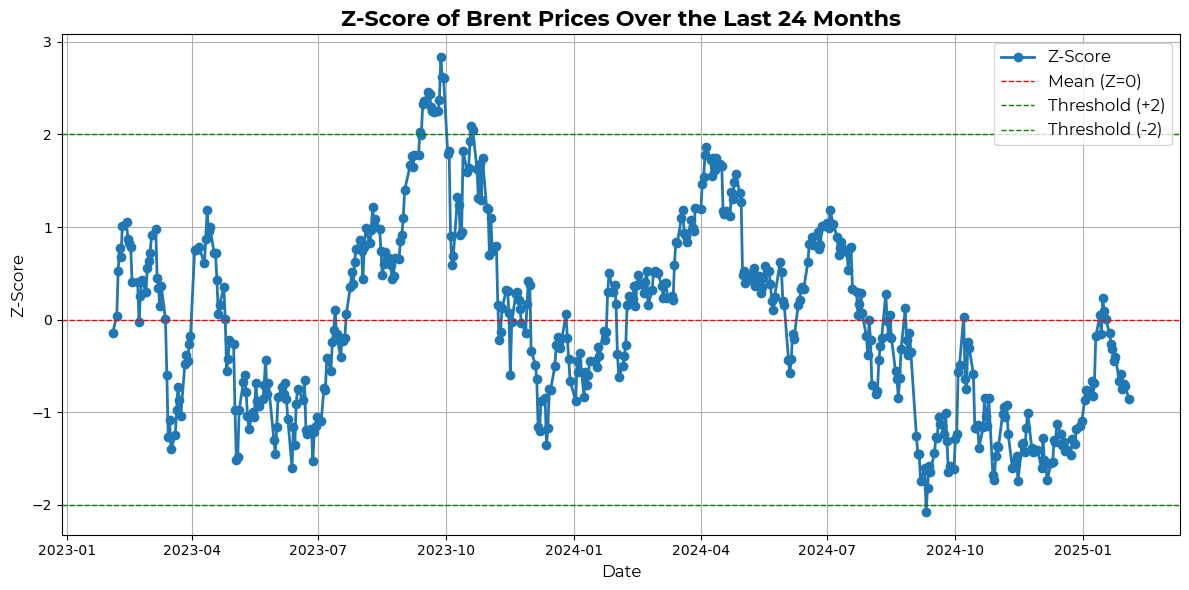

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_17655/1340312056.py:95: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_median = data['Close'].resample('M').median()


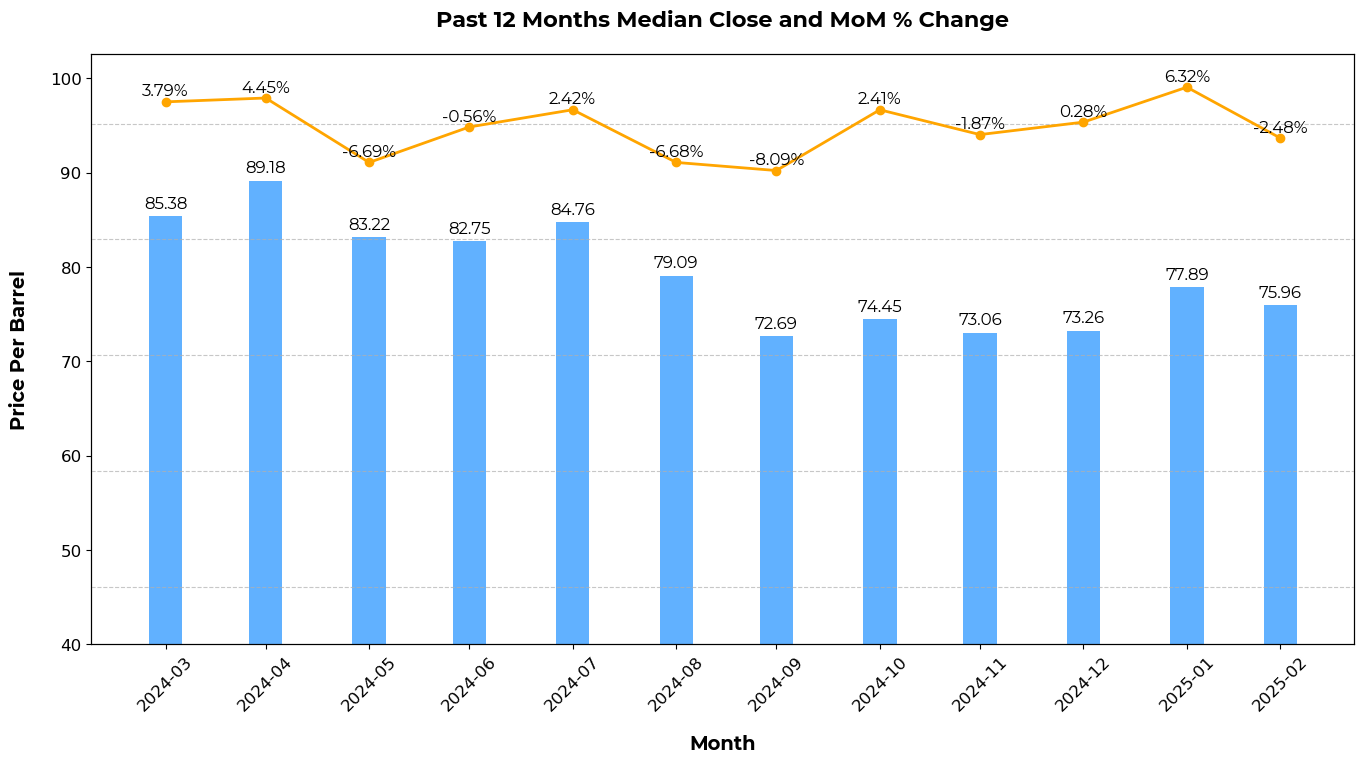

In [4]:

# Call the function
z_scores_data = calculate_z_scores(data)

# Plot the Z-Scores
plot_z_scores(z_scores_data)

# Call the function
plot_median_close_and_mom(data)

In [5]:
# Define a function to fetch Brent contract data
def fetch_brent_contract_data(contract_ticker, start_date, end_date):
    # Fetch data from Yahoo Finance
    contract_data = yf.download(contract_ticker, start=start_date, end=end_date)
    contract_data['Ticker'] = contract_ticker  # Add a column for the ticker
    return contract_data[['Close']]

# Set start and end dates
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=6 * 365)).strftime("%Y-%m-%d")

# Define the tickers for the second and third Brent contracts
brent_second_contract = "BZH25.NYM"  # Replace with actual second contract ticker
brent_third_contract = "BZJ25.NYM"   # Replace with actual third contract ticker

# Fetch data for the second and third contracts
second_contract_data = fetch_brent_contract_data(brent_second_contract, start_date, end_date)
third_contract_data = fetch_brent_contract_data(brent_third_contract, start_date, end_date)

# Rename 'Close' columns for clarity
second_contract_data.rename(columns={'Close': 'Second_Contract_Close'}, inplace=True)
third_contract_data.rename(columns={'Close': 'Third_Contract_Close'}, inplace=True)

# Combine datasets into one based on the date index
combined_data = second_contract_data.join(
    third_contract_data['Third_Contract_Close'], how='outer'
)

# Save the combined dataset to a CSV file
output_file = "../data/raw/brent_combined_contracts.csv"
combined_data.to_csv(output_file)
print(f"Combined data saved to {output_file}")

# Optionally, display the combined dataset
print(combined_data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Combined data saved to ../data/raw/brent_combined_contracts.csv
            Second_Contract_Close  Third_Contract_Close
Date                                                   
2019-02-06              61.230000             61.250000
2019-02-07              61.029999             61.060001
2019-02-08              60.820000             60.849998
2019-02-11              60.630001             60.650002
2019-02-12              60.799999             60.820000



/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_17655/1399658094.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_contract_data.rename(columns={'Close': 'Third_Contract_Close'}, inplace=True)


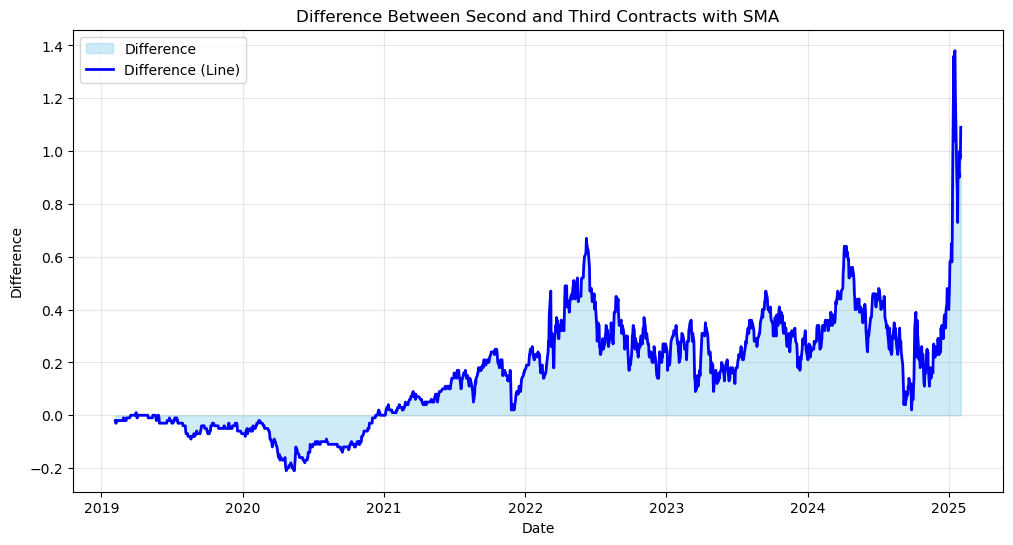

In [6]:
def plot_spread_data(df):
    """
    Plots the area chart for the differences and SMA.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data to plot.
    """
    # Convert 'Date' column to datetime and set it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Calculate difference between second and third contracts
    df['Difference'] = df['Second_Contract_Close'] - df['Third_Contract_Close']

    # # Calculate 3-period Simple Moving Average (SMA)
    # df['SMA_3'] = df['Difference'].rolling(window=3).mean()
    
    plt.figure(figsize=(12, 6))
    plt.fill_between(df.index, df['Difference'], color='skyblue', alpha=0.4, label='Difference')
    plt.plot(df.index, df['Difference'], color='blue', linewidth=2, label='Difference (Line)')
    # plt.plot(df.index, df['SMA_3'], color='orange', linewidth=2, linestyle='--', label='3-Period SMA')
    plt.title('Difference Between Second and Third Contracts with SMA')
    plt.xlabel('Date')
    plt.ylabel('Difference')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
data = pd.read_csv("../data/raw/brent_combined_contracts.csv")
plot_spread_data(data)